# COGS 108 - Final Project 

# Overview

<strong>3-4 sentences summarizing your group's project </strong>

*Fill in your overview here*

# Names / ID

- Lan Wei       
- Sean Race     
- Weilun Yao    
- Shine Paek     
- Kyosuke Goto    

# Group Members IDs

- A########
- A########
- A########
- A########

# Research Question

*Fill in your research question here* (1-2 sentences)

[TODO]

- How does one’s education level affect the likelihood of them committing suicide in the United States? 
- Is it more likely that those who attend top-tier schools have a lower or higher suicide rate?
- Do other factors (sex, age group, GDP, generation) have an effect on the relationship between educational attainment and suicide rates?

## Background and Prior Work

*Fill in your background and prior work here*

<strong>Why is this question of interest to your group? What background information led you to your hypothesis. Why is this important?</strong>

<strong>Find some relevant prior work, and reference those sources. Even if you think you have a totally novel question, find the most similar prior work that you can and discuss how it relates to your project</strong>

<strong>2-3 paragraphs, including at least 2 reference</strong>

[TODO]

Suicide has always been a highly debated topic. As the World Health Organization pointed out, close than 800 000 people die every year due to suicide, which is one person every 40 seconds. Furthermore, suicide rates have even gone up the past decade, making it the 10th leading cause of death worldwide. As an issue then, the causations and correlations of suicide definitely is a topic that is significant and relative to every person.
As a topic of high importance, multiple prior datasets and projects have been done on suicide correlations. World Health Organization has provided many statistics on suicide including gender, age, country, income, and more. Projects and datasets on Kaggle have in addition related socio-economic info with suicide rates by year and country. 
What our project aims to do is to analyze suicidal rates from another aspect which is how educational attainment and learning outcomes affect it. Not surprisingly the relationship between suicide and educational attainment have been analyzed previously too. For example, a research in the scholarly peer reviewed Journal of Affective Disorders has looked at the correlation between educational attainment and completed suicide taking data from the Italian Mortality database. The conclusions that they have come to have sadly shown that “Of both males and females from 15 to 64 years old, suicide victims were significantly more often to have a higher education attainment compared with the same sex and age counterparts died from natural causes. Persons with higher school attainment, compared with those with a maximum primary school degree, had significantly increased odds ratios of dying from a suicide rather than a natural cause.” 
        	Our project wants to furthermore build upon these previous findings and look into this relationship more with data from the states. And in addition, if time permits, we would want to see how other factors such as age, gender, socio-economic status, and so on, affect the relationship between these two factors.
 
References:
- World Health Organization: 
https://www.who.int/mental_health/prevention/suicide/suicideprevent/en/
- Wikipedia: 
https://en.wikipedia.org/wiki/Suicide
- Mental Health, Happiness, Economics, Human Freedom project dataset: 
https://www.kaggle.com/rblcoder/mental-health-happiness-economics-human-freedom/log
- Suicide Rates Overview 1985-2016: 
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016
- Does the level of education influence completed suicide? A nationwide register study: https://www.sciencedirect.com/science/article/pii/S0165032712006179



References (include links):
- 1)
- 2)


# Hypothesis


*Fill in your hypotheses here*

[TODO]

We believe that people with higher educations are more likely to commit suicide than those who did not pursue a higher education after high school/secondary school. We believe this occurs due to the added stress and high expectations placed upon achieving a higher education as well as the disappointment if such expectations are not met.

# Dataset(s)

*Fill in your dataset information here*

<strong>What data will you use to answer your question? Describe the dataset(s) in terms of number of observations, what kind of features it contains, etc. You must use at least one dataset containing at least approximately 1000 observations. You are welcome (and in fact recommended) to find multiple datasets! If you so so, describe each one, and briefly explain how you will combine them together. Include the source of the dataset in the description here.</strong>

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

============================================

[TODO]

Suicide Rates Overview 1985 to 2016
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016
	The suicide data we collected is provided by Kaggle. It is a comprehensive dataset collected by a Kaggle user called Rusty. Both the suicide, GDP, and HDI data in the dataset are gathered from government orginzations: suicde data is from World Health Organization, GDP is from World Bank, and HDI is from United Nation Development Program. Therefore the dataset is one of the most reliable and accurate dataset available to us from the internet.
The dataset contains the number of people suicide in different countries and different age group from year 1985 to 2016. In addition, it also includes the HDI (human development index), GDP (Gross domestic product), and GDP per capita, as a reference of the education, economic and happiness level of people during that year. The dataset also contains an interesting part called “Generation”, which covers people from Boomers, Generation X, Millennials, and other eras. The information about generation allows us to take the historical events into account while analyzing the effect of education on suicide.
	The Human Development Index (HDI) in the dataset is a statistic composite index of life expectancy (health), education, and per capita income (economy). It can be a good factor to represent the effect of education on suicide rate. However, the correlation between HDI and suicide rate may vary from the correlation between education level and suicide rate, since both health and economy are important factors of HDI.

Details about Data:

Variable name
Description 
Note
Country
It is categorical data that divide datasets into multiple sub-datasets in term of country.
Since we only care about the effect of education on suicide rate in the U.S., we will remove other countries from the dataset. 
Year
It is includes year 1985 to 2016
This data allows us to create the trend of suicide rate and compare it with the trend of education level. 
Sex
Categorical: Male and Female
(50% each)
The ratio between male and female in this data is 1:1, which can help us to minimize the gender bias while investigating the effect of eduction level on suicide rate.
We can also use it to investigate the effect of education on suicide rate base on different gender.
age
Categorical: 6 age group
(approximate 17% each)
The age group data is evenly distributed which also minimizes the age bias.
We can also use it to investigate the effect of education on suicide rate base on different age group.
Suicides number
It is the total number of suicide people during the year in different age, gender, and country.
The subgroups of this data gives us the freedom to do both general and detailed analysis. 
Population
It is the number of population of people during the year in different age, gender, and country.


Suicides / 100k pop
It is the suicide ratio
Since some countries, like the U.S. has more population, the total suicide may seems much higher in U.S. compare to other coutries. Therefore we will investigate the effect on suicide rate rather than suicde number to reduce the country and population bias.
Country year
It is the country and year
I.e. (Canada1999) 
Helper data. 
HDI for year
Human Development Index
The HDI are missing in some countries during different year. Therefore we may need to remove rows that don’t contain HDI during analysis. However, since there are only 30% rows contain HDI, the reliability of the inference may be reduced.
GDP for year
Gross Domestic Product
An important index for measuring the economic level in a country 
The GDP measures the economy in the country, which may not be useful for our project. 
However, since GDP and education levels may be positively correlated, we may be able to use it to draw an indirect inference. 
GDP Per Capita
The average GDP level. A measure of individual;s economic level in a country


Generation
The generation the age group belong
The generation data can allow us to take the historical event into account while analyzing the effect of education on suicide rate. 
The generation is not evenly distributed, so there may be some generation bias. However, this also suggests the generation may play an important role in affecting people’s suicide tendency

	Since the HDI data from our first dataset may not be sufficient enough (many missing data, and indirect measure of education) for us to draw a reliable inference of effect of education on suicide rate, we gather some addition datasets with more details about education level.

Center for Disease Control and Prevention
https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm#Mortality_Multiple
This dataset is within the National Vital Statistics System provided by the Center for Disease Control and Prevention. Furthermore it is in the subcategory Mortality Multiple Cause-of-Death. This dataset describes the deaths in the states for the past years starting in 1980. The datasets available for public use are from 2011 to 2017. Variables include:
Resident_Status
Education
Month_Of_Death
Sex
Age
Place_Of_Death
Marital_Status
DOW_of_Death
Data_Year
Injured_At_Work
Manner_Of_Death
Method_Of_Disposition
Autopsy
Place_Of_Causal_Injury
Race
Hispanic_Origin
Etc.
In addition to being very detailed, this dataset also has many entries. For example, in the year 2013 alone there are about 1300725 people recorded. This means that for our project, we have more than enough data to work with. Furthermore, since this dataset has both education aspects and manner-of-death aspects (in which one of the manners is suicide), it is a very good dataset for our research question. 
One of the downsides of this dataset is that it does not have enough economic information, but this is why we have another dataset so that we may be able to analyze economic and income trends and how they play into the relationship between education and suicide. 



# Setup

<strong>Include packages used for analysis in cell provided</strong>

*Fill in your description here*

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import csv
import io
import glob
import gc


# Data Cleaning

Describe your data cleaning steps here.

<strong>What methods did you use to analyze your data? Briefly explain what steps you had to take before you were able to use the datasets you chose to answer your question of interest.
    
   - How 'clean' is the data?
   - What did you have to do to get the data into usable format?
   - What pre-processing steps that were required for your methods (for example, checking data distributions and performing any transformations that may be required)
 
</strong>

In [11]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

### CDC DATA (https://www.cdc.gov/nchs/data/dvs/Record_Layout_2013.pdf)

In [12]:
# Functions

def extractZip(start,end):
    for year in range(start,end+1):
        file = 'mort{}us.zip'.format(year)
        try:
            with ZipFile(file,'r') as z:
                z.extractall()
                
        except FileNotFoundError:
            print('MISSING ' + file)
        else:
            print('UNZIPPED ' + file)


def read_data(filename):
    fields = ['Data year',
              'Manner of Death',
              'Sex',
              'Race',
              'Education Reporting Flag',
              'Education 1989 Revision',
              'Education 2003 Revision',
              'Age Recode 52',
              'Hispanic origin']

    out = io.StringIO()
    cw = csv.DictWriter(out,fields)
    cw.writeheader()

    with open(filename,'r') as inFile:
        for line in inFile:
            row = {
                'Education 1989 Revision' :line[60:62],
                'Education 2003 Revision' :line[62],
                'Education Reporting Flag':line[63],
                'Sex'                     :line[68],
                'Age Recode 52'           :line[74:76],
                'Data year'               :line[101:105],
                'Manner of Death'         :line[106],
                'Race'                    :line[444:446],
                'Hispanic origin'         :line[483:486]            
              }
            cw.writerow(row)

    out.seek(0)
    return pd.read_csv(out, dtype=object)


def get_cdf(start, end):
    dfs = []
    for year in range(start%100,(end+1)%100):
        file = 'VS{}MORT.DUSMCPUB'.format(year)
        print(file)
        df = read_data(file)

        #Turn empty value into NaN
        df.replace(to_replace=r'^\s+$', value=np.nan, regex=True, inplace=True)
                
        # Show Size
        display(df.shape)
            
        # Show Missing Value
        display(df.isnull().sum())
            
        # Check for Missing Education Data (missing both 1989 and 2003)
        no_edu = sum((df['Education 1989 Revision'].isnull()) & (df['Education 2003 Revision'].isnull()))
        assert no_edu == 0    
            
        # Decided to only use 2003 Revision
        # Only keep row with 'Education 2003 Revision'
        df = df[(df['Education Reporting Flag'] == '1')]
        df.drop(labels=['Education 1989 Revision', 'Education Reporting Flag'], axis=1, inplace=True)
        
        # Combine age below 5-9 years old (01~26) to 'Less than 5 years'
        age_lt5 = [ str(i).zfill(2) for i in range(1,27) ]
        df['Age Recode 52'].replace({age: '26' for age in age_lt5}, regex=True, inplace=True)

        # Combine age above 90 years old (44~51) to '90 years and over'
        age_gt90 = [ str(i) for i in range(44,52) ]
        df['Age Recode 52'].replace({age: '44' for age in age_gt90}, regex=True, inplace=True)
        
        dfs.append(df)
        
        del df
        gc.collect()
        
    return pd.concat(dfs)


In [14]:

## Extract zip (Run if you need to)
#extractZip(start=2013, end=2017)

## DEBUG : Make sure data file exist for 2013-2017
#assert len(glob.glob('VS1[3-7]MORT.DUSMCPUB')) == 5

## Create table from years 2013-2017
#cdf = get_cdf(start=2013, end=2017)


In [6]:
## Rename Columns
#cdf.rename({'Data year':'Year',
#            'Manner of Death':'Cause',
#            'Place of Death':'Location',
#            'Education 2003 Revision':'Education',
#            'Age Recode 52':'Age'
#           }, axis=1, inplace=True)
#cdf.head()

In [15]:
# Convert IDs to actual meaning

cause_dict = {  '1': 'Accident',
                '2': 'Suicide',
                '3': 'Homicide',
                '4': 'Pending Investigation',
                '5': 'Could not determine',
                '6': 'Self-Inflicted',
                '7': 'Natural' }

edu_dict = { '1': '8th grade or less',
             '2': '9-12th grade, no diploma',
             '3': 'high school graduate or GED completed',
             '4': 'some college credit, but no degree',
             '5': 'Associate degree',
             '6': "Bachelor's degree",
             '7': "Master's degree",
             '8': 'Doctorate or Professional degree',
             '9': 'Unknown' }

age_dict = { '26':'Less than 5 years',
             '27':'5 - 9 years',
             '28':'10 - 14 years',
             '29':'15 - 19 years',
             '30':'20 - 24 years',
             '31':'25 - 29 years',
             '32':'30 - 34 years',
             '33':'35 - 39 years',
             '34':'40 - 44 years',
             '35':'45 - 49 years',
             '36':'50 - 54 years',
             '37':'55 - 59 years',
             '38':'60 - 64 years',
             '39':'65 - 69 years',
             '40':'70 - 74 years',
             '41':'75 - 79 years',
             '42':'80 - 84 years',
             '43':'85 - 89 years',
             '44':'90 years and over',
             '52':'Age not stated'}

race_dict = { '01':'White',
              '02':'Black',
              '03':'American Indian (Includes Aleuts and Eskimos)',
              '04':'Chinese',
              '05':'Japanese',
              '06':'Hawaiian (includes Part-Hawaiian)',
              '07':'Filipino',
              '08':'Other Asian or Pacific Islander',
              '18':'Asian Indian',
              '28':'Korean',
              '38':'Samoan',
              '48':'Vietnamese',
              '58':'Guamanian',
              '68':'Other Asian or Pacific Islander',
              '78':'Combined other Asian or Pacific Islander',
              '00':'Other races' }



#cdf['Cause'] = cdf['Cause'].map(cause_dict)
#cdf['Education'] = cdf['Education'].map(edu_dict)
#cdf['Age'] = cdf['Age'].map(age_dict)
#cdf['Race'] = cdf['Race'].map(race_dict)


In [16]:
## Write processed data to file
#cdf.to_csv('MORT_13_17.csv', index=False)

In [17]:
# USE THIS
cdf = pd.read_csv('MORT_13_17.csv', dtype=object)

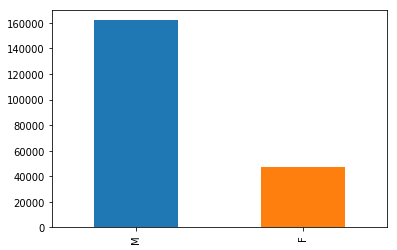

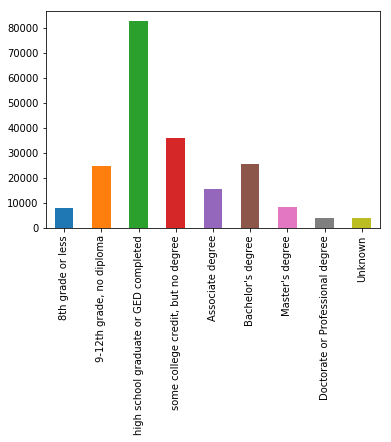

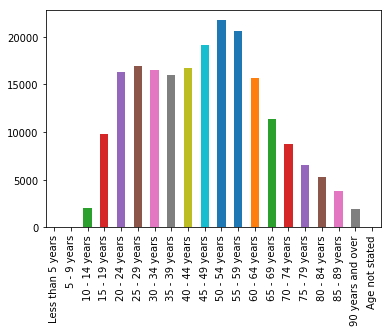

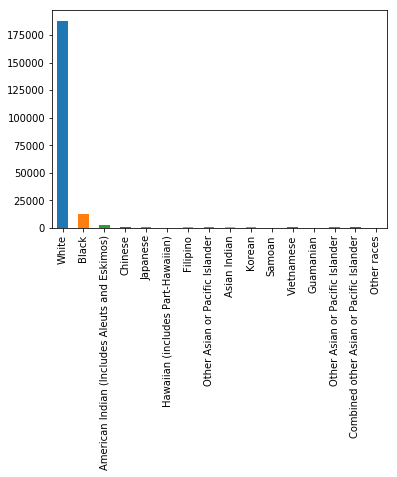

In [18]:
# Suicide Death
cdf[cdf['Cause'] == 'Suicide']['Sex'].value_counts().plot.bar()
plt.show()
cdf[cdf['Cause'] == 'Suicide']['Education'].value_counts().reindex(list(edu_dict.values())).plot.bar()
plt.show()
cdf[cdf['Cause'] == 'Suicide']['Age'].value_counts().reindex(list(age_dict.values())).plot.bar()
plt.show()
cdf[cdf['Cause'] == 'Suicide']['Race'].value_counts().reindex(list(race_dict.values())).plot.bar()
plt.show()

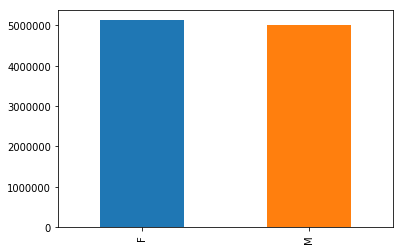

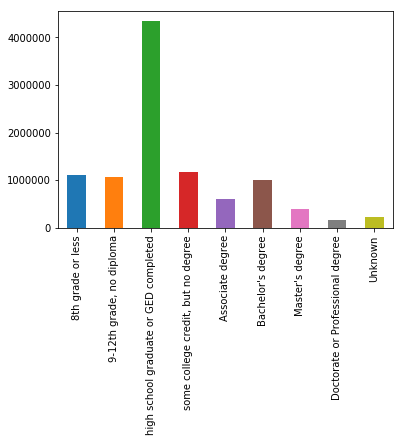

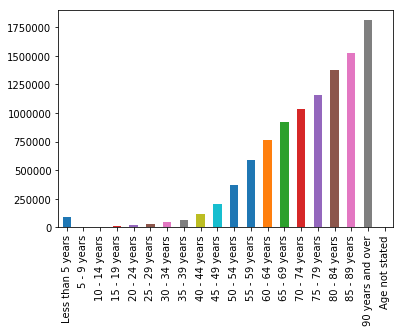

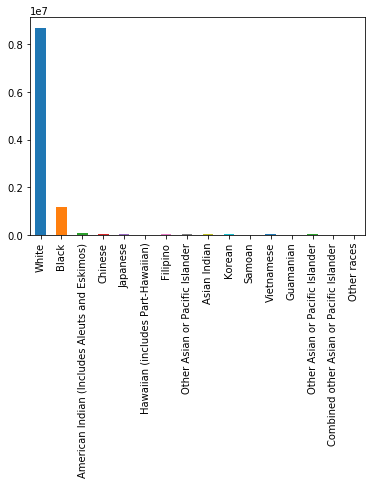

In [19]:
# Natural Death
cdf[cdf['Cause'] == 'Natural']['Sex'].value_counts().plot.bar()
plt.show()
cdf[cdf['Cause'] == 'Natural']['Education'].value_counts().reindex(list(edu_dict.values())).plot.bar()
plt.show()
cdf[cdf['Cause'] == 'Natural']['Age'].value_counts().reindex(list(age_dict.values())).plot.bar()
plt.show()
cdf[cdf['Cause'] == 'Natural']['Race'].value_counts().reindex(list(race_dict.values())).plot.bar()
plt.show()

# Data Visualization

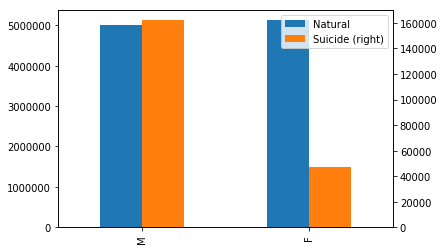

In [65]:
#suicide deaths vs natural deaths by gender
#get value_counts of both Natural and Suicide deaths
NG = cdf[cdf['Cause'] == 'Natural']['Sex'].value_counts()
SG = cdf[cdf['Cause'] == 'Suicide']['Sex'].value_counts()
#debugging
"""
print('Natural Deaths by Gender:')
print(NG)
print()
print('Suicide Deaths by Gender:')
print(SG)
"""
#convert value counts to list
NGL = NG.tolist()
SGL = SG.tolist()
#combine value counts into new dataframe
CombinedGenderData = pd.DataFrame({'Natural': [NGL[1], NGL[0]],'Suicide': [SGL[0], SGL[1]]},index=['M','F'])
#calibrate natural and suicide deaths each based on their own y-axis
CombinedGenderData.plot(kind='bar',secondary_y= 'Suicide')
plt.show()

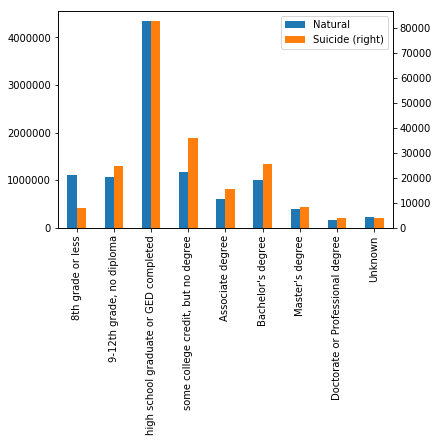

In [68]:
#suicide deaths vs natural deaths by education
#get value_counts of both Natural and Suicide deaths by education
NE = cdf[cdf['Cause'] == 'Natural']['Education'].value_counts().reindex(list(edu_dict.values()))
SE = cdf[cdf['Cause'] == 'Suicide']['Education'].value_counts().reindex(list(edu_dict.values()))
#debugging
"""
print('Natural Deaths by Education:')
print(NE)
print()
print('Suicide Deaths by Education:')
print(SE)
"""
#convert value counts to list
NEL = NE.tolist()
SEL = SE.tolist()
#combine value counts into new dataframe
CombinedEducationData = pd.DataFrame({'Natural': NEL,'Suicide': SEL},index=list(edu_dict.values()))
#calibrate natural and suicide deaths each based on their own y-axis
CombinedEducationData.plot(kind='bar',secondary_y= 'Suicide')
plt.show()

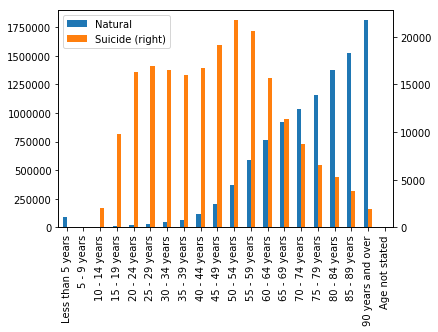

In [69]:
#suicide deaths vs natural deaths by age
#cdf[cdf['Cause'] == 'Natural']['Age'].value_counts().reindex(list(age_dict.values())).plot.bar()
#get value_counts of both Natural and Suicide deaths by age
NA = cdf[cdf['Cause'] == 'Natural']['Age'].value_counts().reindex(list(age_dict.values()))
SA = cdf[cdf['Cause'] == 'Suicide']['Age'].value_counts().reindex(list(age_dict.values()))
#debugging
"""
print('Natural Deaths by Age:')
print(NA)
print()
print('Suicide Deaths by Age:')
print(SA)
"""
#convert value counts to list
NAL = NA.tolist()
SAL = SA.tolist()
#combine value counts into new dataframe
CombinedAgeData = pd.DataFrame({'Natural': NAL,'Suicide': SAL},index=list(age_dict.values()))
#calibrate natural and suicide deaths each based on their own y-axis
CombinedAgeData.plot(kind='bar',secondary_y= 'Suicide')
plt.show()

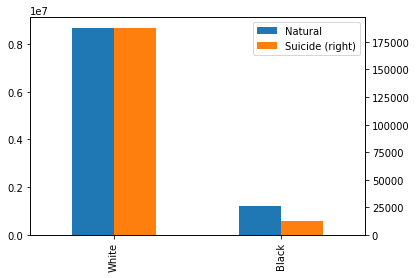

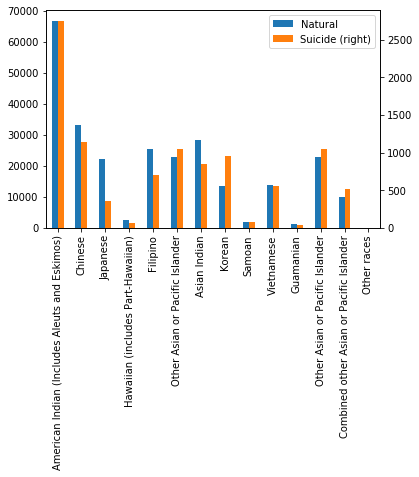

In [70]:
#suicide deaths vs natural deaths by race
#cdf[cdf['Cause'] == 'Natural']['Race'].value_counts().reindex(list(race_dict.values())).plot.bar()
#get value_counts of both Natural and Suicide deaths by age
NR = cdf[cdf['Cause'] == 'Natural']['Race'].value_counts().reindex(list(race_dict.values()))
SR = cdf[cdf['Cause'] == 'Suicide']['Race'].value_counts().reindex(list(race_dict.values()))
#debugging
"""
print('Natural Deaths by Race:')
print(N)
print()
print('Suicide Deaths by Race:')
print(S)
"""
#convert value counts to list
NRL = NR.tolist()
SRL = SR.tolist()
#create lists for other races other than black or white
NOther = NRL[2:]
SOther = SRL[2:]
otherIndex = list(race_dict.values())[2:]
#combine value counts into new dataframe
CombinedRaceWBData = pd.DataFrame({'Natural': [NRL[0],NRL[1]],'Suicide': [SRL[0],SRL[1]]},index=['White','Black'])
CombinedRaceOtherData = pd.DataFrame({'Natural': NOther,'Suicide': SOther},index=otherIndex)
#calibrate natural and suicide deaths each based on their own y-axis
CombinedRaceWBData.plot(kind='bar',secondary_y= 'Suicide')
CombinedRaceOtherData.plot(kind='bar',secondary_y= 'Suicide')
plt.show()

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

<strong>
EDA
   
   - What distributions do your variables take?
   - Are there any outliers?
   - Relationship between variables?
   
   
Analysis

   - What approaches did you use? Why?
   - What were the results?
   - What were your interpretation of these findings?
    
There must be AT LEAST THREE appropriate data visualizations throughout these sections. Each visualization must include an interpretation of what is displayed AND what should be learned from that visualization. Be sure that the appropriate type of visualization is generated given the data that you have, axes are all labeled, and the visualizations clearly communicate the point you're trying to make.
</strong>

In [62]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

In [80]:
#Ratio for natural deaths : Gender
nMale = NG[1]/(NG[1]+NG[0])
nFemale = NG[0]/(NG[1]+NG[0])
print('The ratio of Male to Female for Natural deaths is: Male ' + str(nMale*100)
     + ' to Female ' + str(nFemale*100))
#Ratio for suicidal deaths : Gender
sMale = SG[0]/(SG[1]+SG[0])
sFemale = SG[1]/(SG[1]+SG[0])
print('The ratio of Male to Female for Suicidal deaths is: Male ' + str(sMale*100)
     + ' to Female ' + str(sFemale*100))

The ratio of Male to Female for Natural deaths is: Male 49.3556897224 to Female 50.6443102776
The ratio of Male to Female for Suicidal deaths is: Male 77.4304577591 to Female 22.5695422409


In [115]:
#Mean of Age for Natural Deaths

#create natural death age dictionary from age range values and descriptions
nAgeDict = dict(zip(list(age_dict.values()), NA))

#get the mean value in the dictionary
nMeanPos = 0
for i in NA:
    nMeanPos = nMeanPos + i
nMeanPos = nMeanPos/2

#get the key(description) for the mean age range
nSum = 0
nMeanAge = ""
for key,value in nAgeDict.items():
    nSum = nSum + value
    if nSum > nMeanPos:
        break
    nMeanAge = key
print('The mean of ages for natural deaths is : ' + nMeanAge)
print()
#Mean of Age for Suicidal Deaths

#create suicidal death age dictionary from age range values and descriptions
sAgeDict = dict(zip(list(age_dict.values()), SA))

#delete first entry because first value is NaN
del sAgeDict['Less than 5 years']

#get the mean value in the dictionary
sMeanPos = 0
for key,value in sAgeDict.items():
    sMeanPos = sMeanPos + value
sMeanPos = sMeanPos/2

#get the key(description) for the mean age range
sSum = 0
sMeanAge = ""
for key,value in sAgeDict.items():
    sSum = sSum + value
    if sSum > sMeanPos:
        break
    sMeanAge = key
print('The mean of ages for suicidal deaths is : ' + sMeanAge)

The mean of ages for natural deaths is : 70 - 74 years

The mean of ages for suicidal deaths is : 40 - 44 years


In [116]:
#Mean of Education for Natural Deaths

#create natural death education dictionary from education values and descriptions
nEduDict = dict(zip(list(edu_dict.values()), NE))

#get the mean value in the dictionary
nMeanPos = 0
for i in NA:
    nMeanPos = nMeanPos + i
nMeanPos = nMeanPos/2

#get the key(description) for the mean age range
nSum = 0
nMeanEdu = ""
for key,value in nEduDict.items():
    nSum = nSum + value
    if nSum > nMeanPos:
        break
    nMeanEdu = key
print('The mean of education for natural deaths is : ' + nMeanEdu)
print()
#Mean of Education for Suicidal Deaths

#create suicidal death education dictionary from education values and descriptions
sEduDict = dict(zip(list(edu_dict.values()), SE))

#get the mean value in the dictionary
sMeanPos = 0
for key,value in sEduDict.items():
    sMeanPos = sMeanPos + value
sMeanPos = sMeanPos/2

#get the key(description) for the mean age range
sSum = 0
sMeanEdu = ""
for key,value in sEduDict.items():
    sSum = sSum + value
    if sSum > sMeanPos:
        break
    sMeanEdu = key
print('The mean of education for suicidal deaths is : ' + sMeanEdu)


"""IMPORTANT NOTE: in analyzation we can use this to say that even though this 
seems to show that there is no difference, this is probably because the majority
of people are high school graduates. Therefore we need another analyzation method,
which we will do later (I was thinking of calculating the mean of differences in ratio
for natural deaths vs suicidal deaths for people who have education above 8th grade.
Then we calculate the distribution/etc. similar to HW4 and see if the difference is 
significant or not. In addition we can then do something similar to the analyzation 
in homework A4, where we split by gender <aka is the difference in suicidal education 
data due to gender>

I think this is probably the best we can do given the time we have. Also, note that
these are some of the questions in the final project assignment, which we should
probably do also:

What distributions?
Outliers?
Relationship between variables?  (This kind of overlaps with what I described above
so yeah... we can be flexible on how to answer these questions)
)"""

The mean of education for natural deaths is : 9-12th grade, no diploma

The mean of education for suicidal deaths is : 9-12th grade, no diploma


# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

<strong>
Briefly acknowledge and address any potential issues of ethics and privacy for the proposed project. In particular:
    
- Did you have permission to use this data, for this purpose?  
- Are there privacy concerns regarding your datasets that you need to deal with, and/or terms of use that you need to comply with?
- Are there potential biases in your dataset(s), in terms of who is composes, and how it was collected, that may be problematic in terms of it allowing for equitable analysis? (For example, does your data exclude particular populations, or is it likely to reflect particular human biases in a way that could be a problem?)
- Are there any other issues related to your topic area, data, and/or analyses that are potentially prolematic in terms of data privacy and equitable impact?  
- How did you handle issues you identified?
(1 - 2 Paragraphs)
</strong>

[TODO]

The data we accessed to ascertain whether or not our hypothesis was true were all found publicly online, granting us permission to use this data for the purpose of our data research.  Overall, the nature of our data can be regarded as highly controversial. Suicide is a topic that is not often discussed, and analysed even less. Tying such an issue with something so common as education can lead to an oversimplification of the importance of either issue. The focus of our project is to better understand how data from multiple different data sets can be cross analysed with that from others to try and find patterns of positive correlation. Our main purpose is not however to discredit higher education, and name it as an instigator for rising suicide rates. 
Doubly, we must consider that there are often issues of whether or not all proper cases of suicide are reported. It can also be said that those from regions with access to less education, and cases of suicide might also have less resources to go about reporting the incident to any sort of census -- potentially skewing equitable analysis. There is also the concern that given the general controversial nature of a suicide, there may be less reported cases than the true number of cases that actually did occur. 
Regardless of whether or not our hypothesis is proven false, or not, we have to be careful not to imply that correlation necessary results in causation. The correlation of one to another can not, and should not be regarded as a direct effect, and consequence of one another in any context. 


# Conclusion & Discussion

*Fill in your discussion information here*

<strong>
Discuss your project. Summarize your data and question. Briefly describe your analysis. Summarize your results and conclusions. Be sure to mention any limitation of your project. Discuss the impact of this work on society.

(2-3 paragraph)
</strong>